In [1]:
#basic imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import datasets
#param efficient fine tuning
from peft import get_peft_model,LoraConfig

In [2]:
# we will be exploring a simple movie review dataset with roberta base
#with and without lora
from datasets import load_dataset
movie_reviews = load_dataset('cornell-movie-review-data/rotten_tomatoes')

In [3]:
movie_reviews

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

### with LoRA

In [4]:
#exploring dataset
movie_reviews.set_format("pd")

In [5]:
df = movie_reviews['train'][:]

In [6]:
df['wrd_len'] = df['text'].str.split().apply(len)

<Axes: ylabel='wrd_len'>

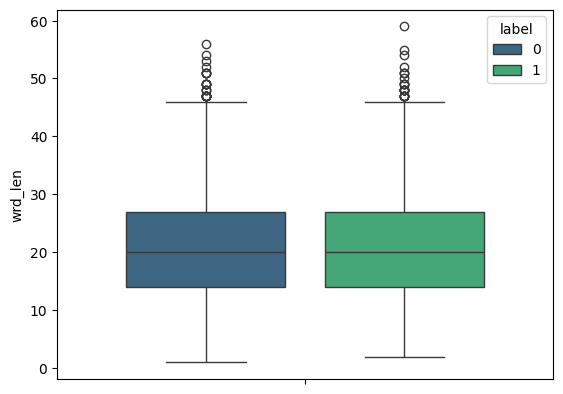

In [7]:
import seaborn as sns
sns.boxplot(y='wrd_len',data=df,hue='label',gap=0.2,palette='viridis')

<Axes: xlabel='label', ylabel='count'>

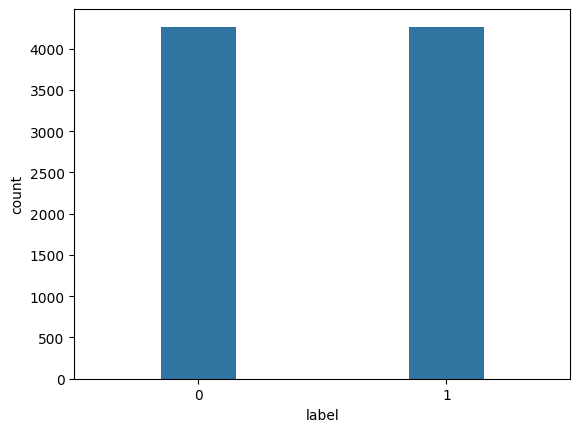

In [8]:
sns.countplot(x='label',data=df,width=0.3)

In [9]:
movie_reviews.reset_format()

### get tokenizer

In [10]:
roberta_path = 'FaceBookAI/roberta-base'

In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(roberta_path)

In [12]:
out = tokenizer("sample text for testing tokenizer")
tokenizer.convert_ids_to_tokens(out['input_ids'])

['<s>', 'sample', 'Ġtext', 'Ġfor', 'Ġtesting', 'Ġtoken', 'izer', '</s>']

### encode dataset

In [13]:
def apply_tokenizer(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

In [14]:
reviews_enc = movie_reviews.map(apply_tokenizer,batched=True,batch_size=None)

Parameter 'function'=<function apply_tokenizer at 0x3242880d0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [15]:
reviews_enc.set_format("pt",columns=['input_ids','attention_mask','label'])

In [16]:
reviews_enc['train'][0]

{'label': tensor(1),
 'input_ids': tensor([    0,   627,  3152,    16, 19083,     7,    28,     5,   733,   620,
          3220,    18,    92,    22,  2764,   260,    22,     8,    14,    37,
            18,   164,     7,   146,    10, 17158,   190,  2388,    87,  4709,
           282,   279,  8447,  5557,   329, 47129,  2156,  1236, 12001,    12,
          3998,  5247,  3538,  9656,  1794,    50, 11235,  2987,   842,  9487,
           479,     2,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0])}

### load model

In [60]:
from transformers import AutoModelForSequenceClassification
num_labels = 2
device = torch.device("mps")
model = (AutoModelForSequenceClassification.from_pretrained(roberta_path,num_labels=num_labels).to(device))

In [18]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### define lora config

In [19]:
config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias='none',
    target_modules=["query", "key" "value"],
    modules_to_save=['classifier'],
    task_type="SEQ_CLS"  # Added this
)

In [20]:
model_lora = get_peft_model(model,config)

In [21]:
model_lora.print_trainable_parameters()

trainable params: 739,586 || all params: 125,386,756 || trainable%: 0.5898


In [22]:
# we will be traning about 70% of params
from transformers import TrainingArguments
model_name = 'LoRA_Roberta_Sentiment_Analysis'
batch_size = 16
logging_steps = len(reviews_enc['train'])//batch_size
weight_decay = 0.01
learning_rate = 2e-5
num_train_epochs=1
training_args = TrainingArguments(output_dir = model_name,
                                num_train_epochs=3,
                                learning_rate=2e-5,
                                per_device_eval_batch_size=16,
                                per_device_train_batch_size=16,
                                weight_decay=0.01,
                                disable_tqdm = False,
                                log_level='error',
                                eval_strategy='epoch',
                                push_to_hub=False,
                                logging_steps=len(reviews_enc['train'])//16)

In [23]:
from sklearn.metrics import f1_score,accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds)
    acc = accuracy_score(labels,preds)
    return {'f1':f1,'acc':acc}

In [24]:
from transformers import Trainer
trainer = Trainer(model=model_lora,
                   train_dataset=reviews_enc['train'],
                   eval_dataset=reviews_enc['validation'],
                   compute_metrics=compute_metrics,
                   args = training_args,
                   processing_class=tokenizer)

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.688900,0.678346,0.689610,0.551595
2,0.633600,0.562852,0.817006,0.814259
3,0.530500,0.496035,0.825427,0.827392


TrainOutput(global_step=1602, training_loss=0.6174681493256721, metrics={'train_runtime': 276.2657, 'train_samples_per_second': 92.628, 'train_steps_per_second': 5.799, 'total_flos': 1061117593171200.0, 'train_loss': 0.6174681493256721, 'epoch': 3.0})

### comparing it to a standard model

In [26]:
num_labels = 2
device = torch.device("mps")
model_std = (AutoModelForSequenceClassification.from_pretrained(roberta_path,num_labels=num_labels).to(device))

In [27]:
output_dir = 'StdRoBERTa_sentiment'
training_args_2 = TrainingArguments(output_dir = output_dir,
                                num_train_epochs=3,
                                learning_rate=2e-5,
                                per_device_eval_batch_size=16,
                                per_device_train_batch_size=16,
                                weight_decay=0.01,
                                disable_tqdm = False,
                                log_level='error',
                                eval_strategy='epoch',
                                push_to_hub=False,
                                logging_steps=len(reviews_enc['train'])//16)

In [28]:
trainer_2 = Trainer(model=model_std,
                   train_dataset=reviews_enc['train'],
                   eval_dataset=reviews_enc['validation'],
                   compute_metrics=compute_metrics,
                   args = training_args_2,
                   processing_class=tokenizer)

In [29]:
trainer_2.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.401300,0.366761,0.862215,0.847092
2,0.237500,0.382324,0.886216,0.884615
3,0.164400,0.446008,0.888067,0.886492


TrainOutput(global_step=1602, training_loss=0.2674489597628328, metrics={'train_runtime': 466.631, 'train_samples_per_second': 54.84, 'train_steps_per_second': 3.433, 'total_flos': 1052033110416000.0, 'train_loss': 0.2674489597628328, 'epoch': 3.0})

In [103]:
import plotly.graph_objects as go

# Data from TrainOutput
metrics_1 = {
    'train_runtime': 276.2657,
    'train_samples_per_second': 92.628,
    'train_steps_per_second': 5.799,
}
metrics_2 = {
    'train_runtime': 466.631,
    'train_samples_per_second': 54.84,
    'train_steps_per_second': 3.433,
}

# Labels for the metrics
labels = list(metrics_1.keys())

# Values for each TrainOutput
values_1 = list(metrics_1.values())
values_2 = list(metrics_2.values())

# Create a bar chart
fig = go.Figure()

# TrainOutput 1 Bar
fig.add_trace(go.Bar(
    x=labels,
    y=values_1,
    name='TrainOutput 1',
    marker_color='#00FFFF',width=0.3  # Neon blue
))

# TrainOutput 2 Bar
fig.add_trace(go.Bar(
    x=labels,
    y=values_2,
    name='TrainOutput 2',
    marker_color='#FFA700',width=0.3  # Orange
))

# Update layout for better visualization
fig.update_layout(
    title='Comparison of Training Metrics',
    xaxis_title='Metrics',
    yaxis_title='Values',
    barmode='group',
    template='plotly_dark',  # Black background
    legend_title='TrainOutput',
    font=dict(color='white'),  # White font for readability
    title_font=dict(size=20, color='white')  # Title styling
)

# Show the plot
fig.show()

In [56]:
#lora model took 60% of traning time
ratio = 276.2675/466.631
ratio

0.5920470350233911

In [53]:
trainer_2.predict(reviews_enc['test'])

PredictionOutput(predictions=array([[-2.6887238,  3.046571 ],
       [-2.9399302,  3.248121 ],
       [ 2.4063866, -2.5439239],
       ...,
       [ 2.7382324, -2.855234 ],
       [ 3.1420493, -2.9627957],
       [ 3.0205295, -2.911239 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0]), metrics={'test_loss': 0.49854007363319397, 'test_f1': 0.8806818181818182, 'test_acc': 0.8818011257035647, 'test_runtime': 4.6959, 'test_samples_per_second': 227.005, 'test_steps_per_second': 14.268})

In [54]:
trainer.predict(reviews_enc['test'])

PredictionOutput(predictions=array([[-0.36226887,  0.44704443],
       [-0.39034158,  0.46337628],
       [ 0.27648503, -0.1625298 ],
       ...,
       [ 0.35031015, -0.23003908],
       [ 0.29074046, -0.16602106],
       [ 0.4881972 , -0.4046697 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0]), metrics={'test_loss': 0.49986910820007324, 'test_f1': 0.8156638013371538, 'test_acc': 0.8189493433395872, 'test_runtime': 4.4067, 'test_samples_per_second': 241.906, 'test_steps_per_second': 15.204})

In [74]:
import plotly.graph_objects as go

# Data for Standard and LoRA models
std_metrics = {
    'test_loss': 0.49854007363319397,
    'test_f1': 0.8806818181818182,
    'test_acc': 0.8818011257035647,
}

lora_metrics = {
    'test_loss': 0.49986910820007324,
    'test_f1': 0.8156638013371538,
    'test_acc': 0.8189493433395872,
}

# Labels for the metrics
labels = list(std_metrics.keys())

# Values for each model
std_values = list(std_metrics.values())
lora_values = list(lora_metrics.values())

# Create a bar chart
fig = go.Figure()

# Standard Model Bar
fig.add_trace(go.Bar(
    x=labels,
    y=std_values,
    name='Standard Model',
    marker_color='#4169e1',width=0.3 # Neon blue
))

# LoRA Model Bar
fig.add_trace(go.Bar(
    x=labels,
    y=lora_values,
    name='LoRA Model',
    marker_color='#FF3131',width=0.3  # Orange
))

# Update layout for better visualization
fig.update_layout(
    title='Comparison of Test Metrics: Standard vs. LoRA Model',
    xaxis_title='Metrics',
    yaxis_title='Values',
    barmode='group',
    template='plotly_dark',  # Black background
    legend_title='Model Type',
    font=dict(color='white'),  # White font for readability
    title_font=dict(size=20, color='white')  # Title styling
)

# Show the plot
fig.show()

### LoRA model with r=8 and alpha =16, did train in 60% of base models time but its f1 score also dropped from 88 to 81

## Iteration 2 r=16,alpha=64

In [97]:
lora_config2 = LoraConfig(r=16,lora_alpha=64,lora_dropout=0.1,lora_bias='none',target_modules=['query','value'],modules_to_save=['classifier'],task_type='SEQ_CLS')

In [98]:
model_lora_2 = get_peft_model(model,lora_config2)

In [99]:
model_lora_2.print_trainable_parameters()

trainable params: 1,504,514 || all params: 126,151,684 || trainable%: 1.1926


In [100]:
training_args3 = TrainingArguments(output_dir='Lora_model2',
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                   weight_decay=0.01,
                                   log_level="error",
                                   eval_strategy="epoch",
                                   per_device_eval_batch_size=16,
                                   per_device_train_batch_size=16,
                                   disable_tqdm=False,
                                   push_to_hub=False,
                                   logging_steps=len(reviews_enc['train'])//16
                                   )

In [101]:
trainer_3 = Trainer(model = model_lora_2,
                   args = training_args3,
                   train_dataset=reviews_enc['train'],
                   eval_dataset=reviews_enc['validation'],
                   compute_metrics=compute_metrics,
                   processing_class=tokenizer)

In [102]:
trainer_3.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.507400,0.327886,0.863515,0.856473
2,0.322200,0.310586,0.874159,0.877111
3,0.315300,0.304629,0.873714,0.873358


TrainOutput(global_step=1602, training_loss=0.3813712576801857, metrics={'train_runtime': 353.474, 'train_samples_per_second': 72.396, 'train_steps_per_second': 4.532, 'total_flos': 1070513356780800.0, 'train_loss': 0.3813712576801857, 'epoch': 3.0})

In [108]:
import plotly.graph_objects as go

# Data from TrainOutput
metrics_1 = {
    'train_runtime': 276.2657,
    'train_samples_per_second': 92.628,
    'train_steps_per_second': 5.799
}
metrics_2 = {
    'train_runtime': 466.631,
    'train_samples_per_second': 54.84,
    'train_steps_per_second': 3.433
}
metrics_3 = {
    'train_runtime': 353.474, 
    'train_samples_per_second': 72.396,
    'train_steps_per_second': 4.532
}

# Labels for the metrics
labels = list(metrics_1.keys())

# Values for each TrainOutput
values_1 = list(metrics_1.values())
values_2 = list(metrics_2.values())
values_3 = list(metrics_3.values())

# Create a bar chart
fig = go.Figure()

# TrainOutput 1 Bar
fig.add_trace(go.Bar(
    x=labels,
    y=values_1,
    name='LoRA r=8,alpha=16',
    marker_color='#00FFFF',width=0.25  # Neon blue
))

# TrainOutput 2 Bar
fig.add_trace(go.Bar(
    x=labels,
    y=values_2,
    name='Standard base model',
    marker_color='#FFA700',width=0.25  # Orange
))
fig.add_trace(go.Bar(
    x=labels,
    y=values_3,
    name='LoRA r=16,alpha=32',
    marker_color='#8F00FF',width=0.25  # Neon blue
))

# Update layout for better visualization
fig.update_layout(
    title='Comparison of Training Metrics',
    xaxis_title='Metrics',
    yaxis_title='Values',
    barmode='group',
    template='plotly_dark',  # Black background
    legend_title='TrainOutput',
    font=dict(color='white'),  # White font for readability
    title_font=dict(size=20, color='white')  # Title styling
)

# Show the plot
fig.show()

In [110]:
#so we see lorav2 trains in 3/4 of the time, imagine the time savings for models which have billions of params
ratio_lora2 = 353.474/466.631
ratio_lora2

0.7575021805237973

In [111]:
trainer_3.predict(reviews_enc['test'])

PredictionOutput(predictions=array([[-1.7522452,  1.4035374],
       [-2.448044 ,  2.193313 ],
       [ 1.2381396, -1.6578572],
       ...,
       [ 1.4530617, -1.9049678],
       [ 1.5499275, -2.0332992],
       [ 1.2692337, -1.7805047]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0]), metrics={'test_loss': 0.33271998167037964, 'test_f1': 0.8769953051643192, 'test_acc': 0.8771106941838649, 'test_runtime': 5.62, 'test_samples_per_second': 189.68, 'test_steps_per_second': 11.922})

In [120]:
import plotly.graph_objects as go

# Data for Standard and LoRA models
std_metrics = {
    'test_loss': 0.49854007363319397,
    'test_f1': 0.8806818181818182,
    'test_acc': 0.8818011257035647,
}

lora_metrics = {
    'test_loss': 0.49986910820007324,
    'test_f1': 0.8156638013371538,
    'test_acc': 0.8189493433395872,
}
lora2_metrics = {
    'test_loss': 0.33271998167037964,
    'test_f1': 0.8769953051643192, 
    'test_acc': 0.8771106941838649
}

# Labels for the metrics
labels = list(std_metrics.keys())

# Values for each model
std_values = list(std_metrics.values())
lora_values = list(lora_metrics.values())
lora2_values = list(lora2_metrics.values())

# Create a bar chart
fig = go.Figure()

# Standard Model Bar
fig.add_trace(go.Bar(
    x=labels,
    y=std_values,
    name='Standard Model',
    marker_color='#4169e1',width=0.25 # Neon blue
))

# LoRA Model Bar
fig.add_trace(go.Bar(
    x=labels,
    y=lora_values,
    name='LoRA Model',
    marker_color='#FF3131',width=0.25  # Orange
))
fig.add_trace(go.Bar(
    x=labels,
    y=lora2_values,
    name='LoRAv2 Model',
    marker_color='#90EE90',width=0.25 # Neon blue
))
# Update layout for better visualization
fig.update_layout(
    title='Comparison of Test Metrics: Standard vs. LoRA Model',
    xaxis_title='Metrics',
    yaxis_title='Values',
    barmode='group',
    template='plotly_dark',  # Black background
    legend_title='Model Type',
    font=dict(color='white'),  # White font for readability
    title_font=dict(size=20, color='white')  # Title styling
)

# Show the plot
fig.show()

In [121]:
# as we can see LoRA model achives nearly the same results with 75% of trainign time and trainign only 1.2% of total parms